## Analyzing 538 Pollster Ratings
##### Ellen Gentile
#### MSDS 570: Visual and Unstructured Data Analysis
##### 12/05/2024


In [ ]:
#import dependency modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pd.set_option('display.max_columns', None) #show all cols
pd.set_option('display.max_rows', None) #show all rows

In [ ]:
#read in datafiles to dataframes
ratings= pd.read_csv('pollster-ratings-combined.csv')
polls= pd.read_csv('raw_polls.csv')

In [ ]:
#check info about polls dataframe
polls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20466 entries, 0 to 20465
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   poll_id             20466 non-null  int64  
 1   question_id         20466 non-null  int64  
 2   race_id             20466 non-null  int64  
 3   cycle               20466 non-null  int64  
 4   location            20466 non-null  object 
 5   type_simple         20466 non-null  object 
 6   race                20466 non-null  object 
 7   pollster            20466 non-null  object 
 8   pollster_rating_id  20466 non-null  int64  
 9   aapor_roper         20466 non-null  bool   
 10  inactive            20466 non-null  bool   
 11  methodology         16915 non-null  object 
 12  transparency_score  20466 non-null  float64
 13  partisan            2556 non-null   object 
 14  polldate            20466 non-null  object 
 15  electiondate        20466 non-null  object 
 16  time

In [ ]:
#check info about ratings dataframe
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   pollster                             540 non-null    object 
 1   pollster_rating_id                   540 non-null    int64  
 2   aapor_roper                          540 non-null    bool   
 3   inactive                             540 non-null    bool   
 4   numeric_grade                        282 non-null    float64
 5   rank                                 282 non-null    float64
 6   POLLSCORE                            540 non-null    float64
 7   wtd_avg_transparency                 540 non-null    float64
 8   number_polls_pollster_total          540 non-null    int64  
 9   percent_partisan_work                540 non-null    float64
 10  error_ppm                            540 non-null    float64
 11  bias_ppm                        

### Preprocessing / Checking Data Quality

<Axes: >

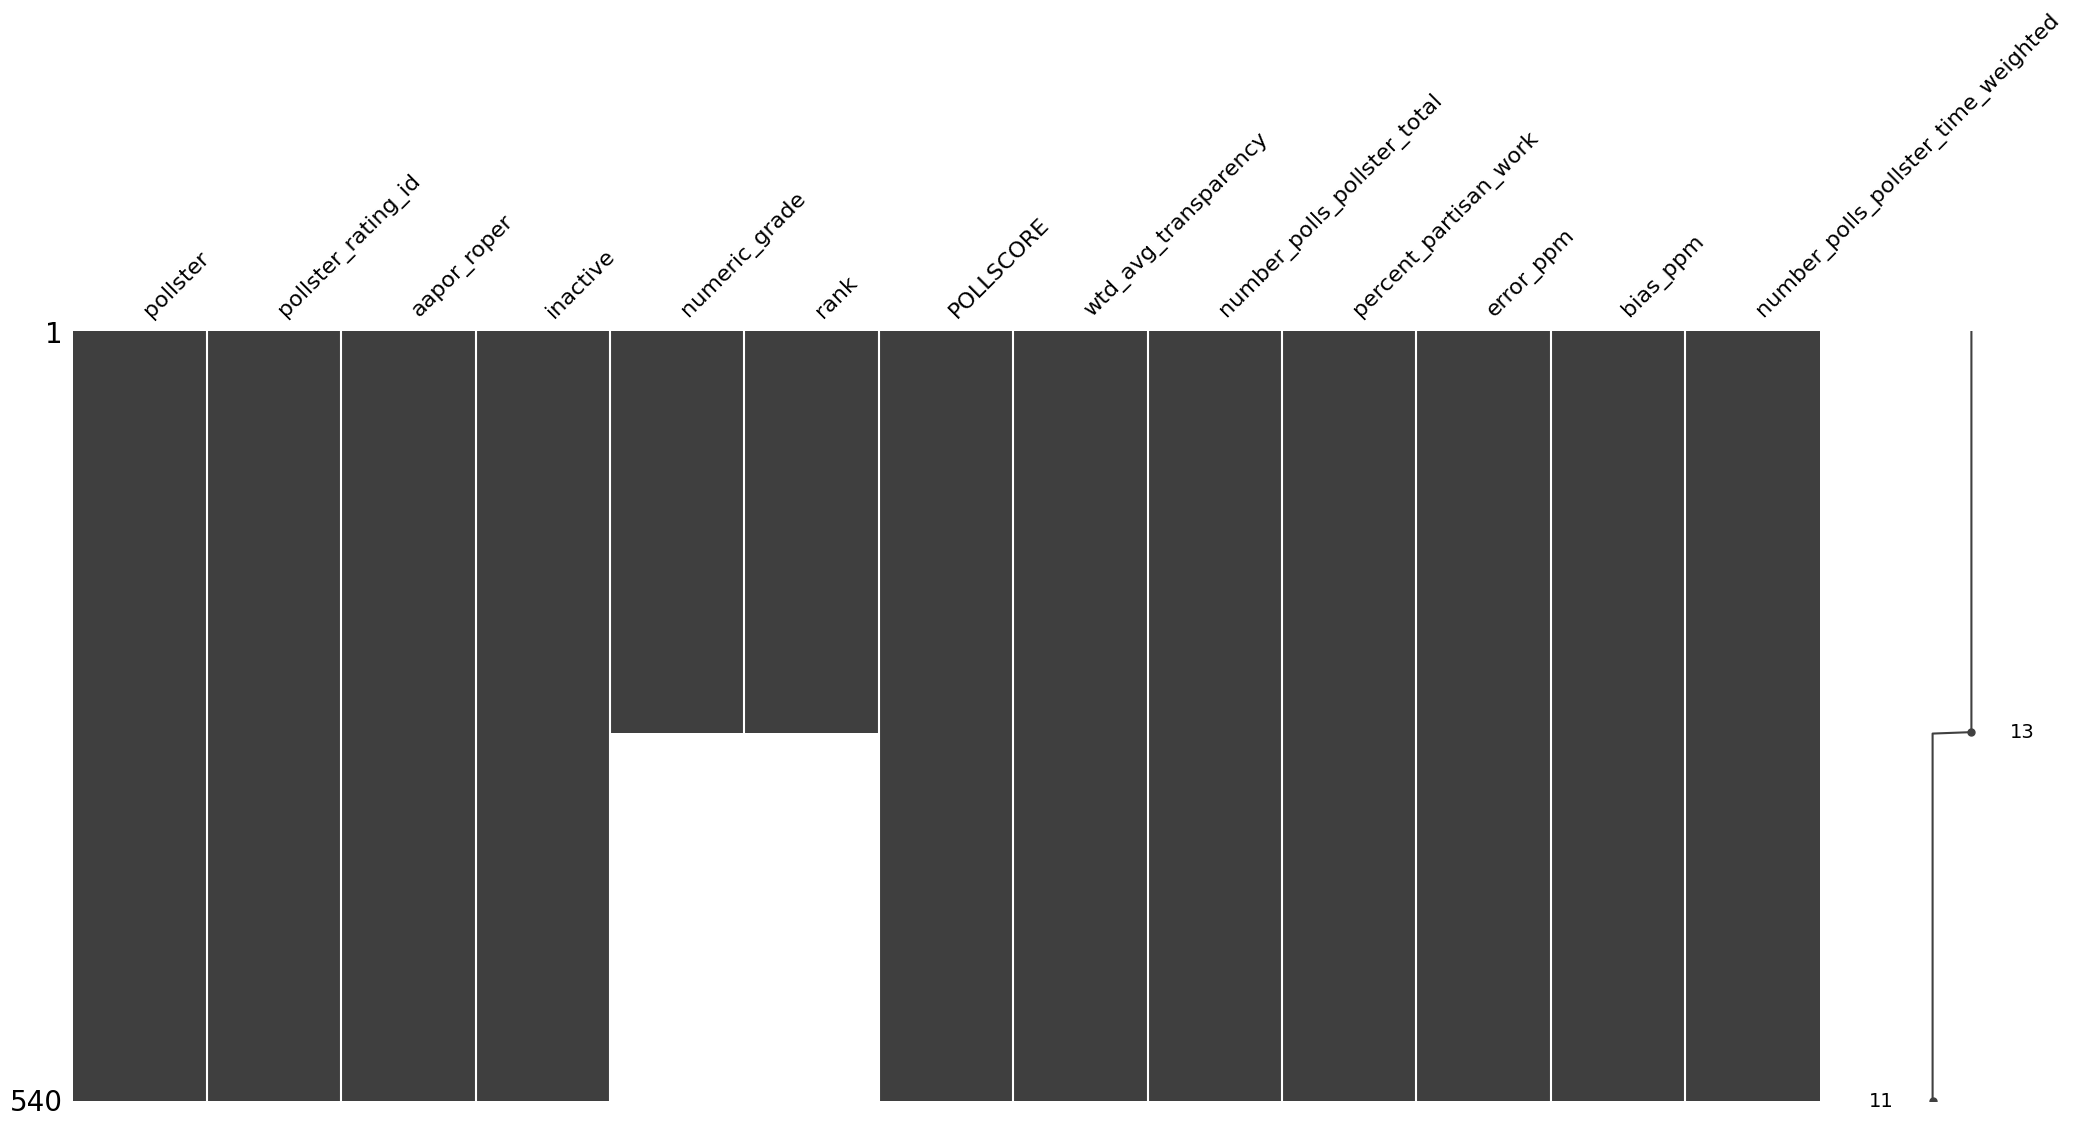

In [ ]:
#check for n/a values
import missingno as msno

msno.matrix(ratings)

Note- Not all pollsters have a numeric grade or a ranking. According to 538's readme (link below) on this dataset pollsters that are flagged as inactive do not receive ratings.

https://github.com/fivethirtyeight/data/blob/master/pollster-ratings/README.md


<Axes: >

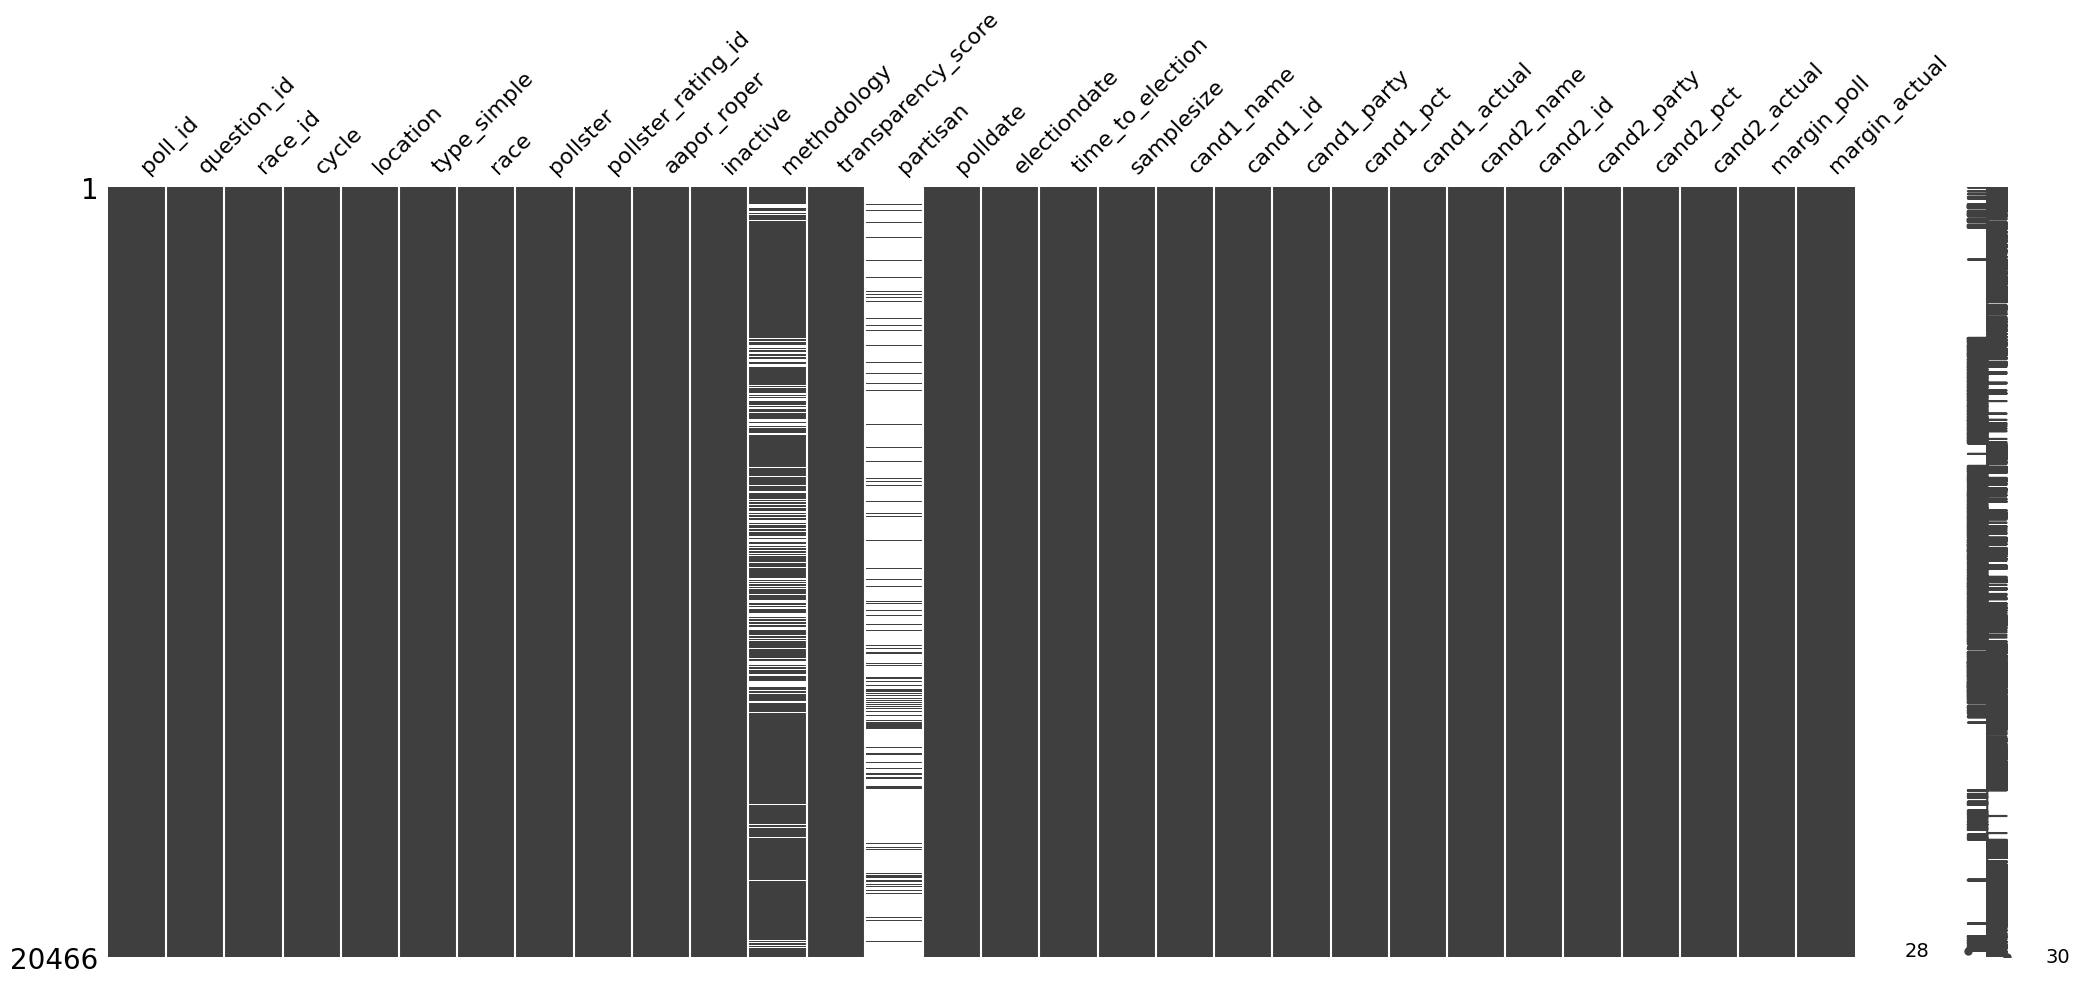

In [ ]:
msno.matrix(polls)

  Note that the Partisan Column has many missing values.  The methodology column also contains quite a few missing values.  Neither of these columns are areas where it would be correct to impute.

According to 538's readme the partisan column on this dataset is defined as the individual sources self defined them, NOT as 538 identified them, and this column may have inconsistent definitions and should be used with care.  Because of this, we will drop it.  The methodology column is only populated for pollsters who are transparent enough to disclose their methods. We will keep this column, but populate N/A's as unknown.

In [ ]:
polls = polls.drop(columns=['partisan'])
polls['methodology'] = polls['methodology'].fillna('Unknown')

In [ ]:
#check for outlier values

In [ ]:
def find_outliers_iqr(df):
  if not isinstance(df, pd.DataFrame):
        return {}

  outliers = {}
  for col in df.select_dtypes(include=np.number): #only numeric columns
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    column_outliers = []
    for index, value in df[col].items():
      if value < lower_bound or value > upper_bound:
        column_outliers.append((value, index))

    if column_outliers:
        outliers[col] = column_outliers

    return outliers

In [ ]:
find_outliers_iqr(ratings)

{}

In [ ]:
find_outliers_iqr(polls)

{}

### No outliers in either data set, so ok to proceed with visualization of data as is, keeping in mind the nulls mentioned previously.

## Exploratory Data Analysis

Now to run descriptive stats on each dataset:

In [ ]:
polls.describe()

,poll_id,question_id,race_id,cycle,pollster_rating_id,transparency_score,time_to_election,samplesize,cand1_id,cand1_pct,cand1_actual,cand2_id,cand2_pct,cand2_actual,margin_poll,margin_actual
count,20466.000000,20466.000000,20466.000000,20466.000000,20466.000000,20466.000000,20466.000000,20466.000000,20466.000000,20466.000000,20466.000000,20466.000000,20466.000000,20466.000000,20466.000000,20466.000000
mean,43023.122545,77578.152399,3256.988518,2011.343839,287.302551,5.592593,23.770595,912.588904,8428.555067,44.824336,48.306247,8500.827323,42.627089,46.365857,2.197248,1.940390
std,23604.133011,48566.862046,3113.028126,6.659597,191.457559,2.259730,17.044266,2117.131186,6850.471173,8.534310,8.114466,6948.512385,8.984777,9.006291,13.842516,14.705409
min,7.000000,2640.000000,1.000000,1998.000000,1.000000,0.000000,1.000000,86.000000,3.000000,3.000000,10.445627,3.000000,0.000000,0.784467,-78.000000,-76.884975
25%,25378.250000,34991.250000,728.000000,2006.000000,154.000000,4.000000,9.000000,500.000000,985.000000,41.000000,44.879242,1111.500000,39.000000,42.744325,-4.000000,-5.006406
50%,46300.000000,79991.500000,1533.000000,2012.000000,267.000000,5.000000,19.000000,632.000000,9207.000000,46.000000,48.834190,9849.000000,44.000000,47.388476,2.000000,2.181319
75%,63998.750000,120093.500000,6249.000000,2016.000000,373.750000,7.000000,37.000000,906.000000,13256.000000,50.000000,52.760206,13254.000000,48.000000,50.922959,9.000000,9.242276
max,84957.000000,188221.000000,9552.000000,2023.000000,814.000000,10.000000,61.000000,134000.000000,30938.000000,97.000000,94.125276,30798.000000,86.000000,87.452826,96.000000,93.340809


Polls data seems to be within acceptable and expected ranges with no perceivable outliers at first glance.
Check ratings data stats:

In [ ]:
ratings.describe()

,pollster_rating_id,numeric_grade,rank,POLLSCORE,wtd_avg_transparency,number_polls_pollster_total,percent_partisan_work,error_ppm,bias_ppm,number_polls_pollster_time_weighted
count,540.000000,282.000000,282.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,322.566667,1.743972,141.500000,0.016481,4.050370,24.755556,0.184444,0.067407,-0.019815,10.389630
std,216.474649,0.593244,81.550598,0.410672,2.207035,83.433172,0.364799,0.398248,0.523507,30.209631
min,1.000000,0.500000,1.000000,-1.500000,0.000000,1.000000,0.000000,-1.200000,-2.000000,0.000000
25%,143.750000,1.300000,71.250000,-0.125000,2.875000,2.000000,0.000000,-0.100000,-0.200000,0.475000
50%,291.500000,1.700000,141.500000,0.000000,3.500000,5.000000,0.000000,0.100000,0.000000,1.900000
75%,470.250000,2.100000,211.750000,0.200000,4.600000,16.000000,0.000000,0.200000,0.300000,6.325000
max,861.000000,3.000000,282.000000,1.800000,10.000000,1101.000000,1.000000,1.900000,2.000000,272.600000


Now lets look at some of the variable distributions

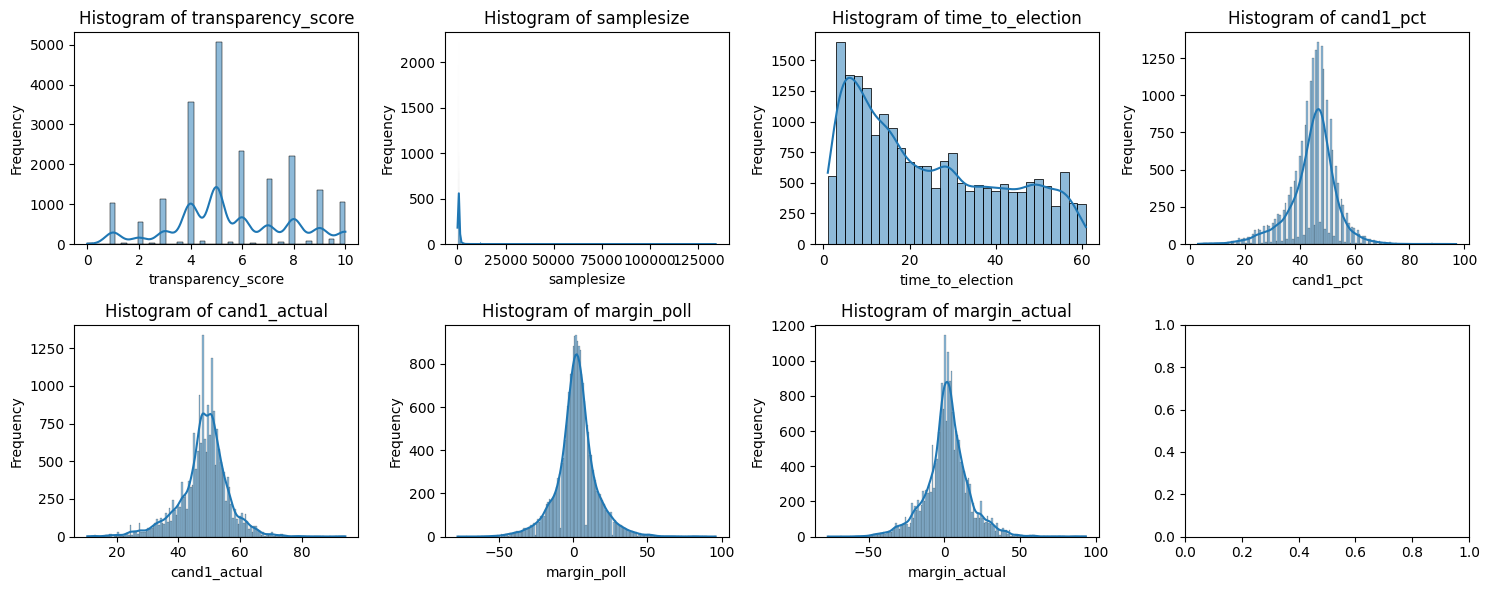

In [ ]:
#Subset dataframe
polls_hist= polls[['transparency_score', 'samplesize','time_to_election', 'cand1_pct','cand1_actual', 'margin_poll','margin_actual']]

# Number of columns
num_cols = len(polls_hist.columns)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))

# Iterate through each column and create a histogram
for i, col in enumerate(polls_hist.columns):
  row_i = i // 4 #row index
  col_i = i % 4 #col index
  sns.histplot(polls_hist[col], ax=axes[row_i, col_i], kde=True)  # Added KDE for better visualization
  axes[row_i, col_i].set_title(f'Histogram of {col}')
  axes[row_i, col_i].set_xlabel(col)
  axes[row_i, col_i].set_ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

* Predicted and actual candidate vote shares, victory margins and transparency scores followed largely normal distributions, though there was a slight left skew to the predicted and actual candidate vote share.

* Time to election is multimodal with the strongest peak approximately one week prior to the election, and subsequent peaks about 1 month prior to the eleciton and about 60 days prior.

* Sample size may have some kind of outlier giving it a long right
skew that makes it difficult to visualize.

Lets look at a boxplot of samplesize:

<Axes: xlabel='samplesize'>

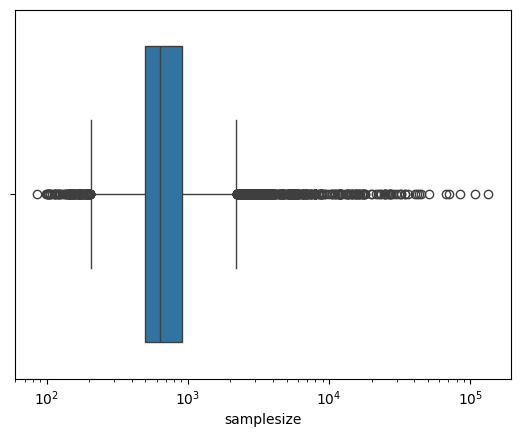

In [ ]:
sns.boxplot(polls['samplesize'], orient='h', log_scale=True) #using log scale to better visualize the data despite the skew

Hypothesis: Election type may have a strong impact on the sample size.

Lets look at the distribution of sample size as it varies by election type to see if this is true:

<Axes: xlabel='samplesize'>

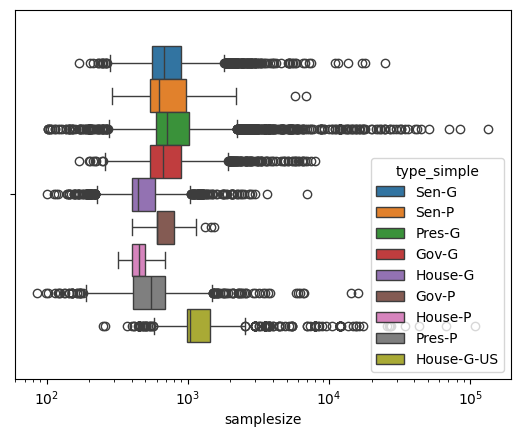

In [ ]:
sns.boxplot(polls, x='samplesize', hue='type_simple', log_scale=True)

All election types have high variability of sample sizes. General House elections overall have the highest sample sizes, while house primaries have the lowest.  



Now lets look at some aggregate statistics of the polls by pollster:

In [ ]:
polls.columns

Index(['poll_id', 'question_id', 'race_id', 'cycle', 'location', 'type_simple',
       'race', 'pollster', 'pollster_rating_id', 'aapor_roper', 'inactive',
       'methodology', 'transparency_score', 'polldate', 'electiondate',
       'time_to_election', 'samplesize', 'cand1_name', 'cand1_id',
       'cand1_party', 'cand1_pct', 'cand1_actual', 'cand2_name', 'cand2_id',
       'cand2_party', 'cand2_pct', 'cand2_actual', 'margin_poll',
       'margin_actual'],
      dtype='object')

In [ ]:
pollster_grouped= polls.groupby('pollster').agg({'poll_id':'nunique', 'question_id':'nunique','race_id':'nunique', 'cycle':'nunique',
                                                 'location':'nunique','type_simple':'nunique', 'race':'nunique', 'pollster_rating_id':'nunique',
                                                 'transparency_score':['min','mean','median', 'max','std','var'],
                                                 'polldate': 'nunique', 'electiondate':'nunique', 'time_to_election':['min','mean','median', 'max','std','var'], 'samplesize':['min','mean','median', 'max','std','var'],
                                                 'cand1_name':'nunique','cand1_party':'nunique','cand1_pct':['min','mean','median', 'max','std','var'], 'cand1_actual':['min','mean','median', 'max','std','var'],
                                                 'cand2_name':'nunique','cand2_party':'nunique','cand2_pct':['min','mean','median', 'max','std','var'], 'cand2_actual':['min','mean','median', 'max','std','var'],
                                                 'margin_poll':['min','mean','median', 'max','std','var'], 'margin_actual':['min','mean','median', 'max','std','var']})
pollster_grouped.head()

poll_id question_id race_id   cycle location  \
                             nunique     nunique nunique nunique  nunique   
1892 Polling                     4.0         4.0     4.0     3.0      4.0   
1st Tuesday Campaigns            2.0         2.0     2.0     1.0      2.0   
20/20 Insight                    7.0         9.0     6.0     3.0      3.0   
A&A Research                     3.0         4.0     4.0     2.0      3.0   
ABC News/The Washington Post   124.0       145.0    62.0    17.0     14.0   

                             type_simple    race pollster_rating_id  \
                                 nunique nunique            nunique   
1892 Polling                         3.0     4.0                1.0   
1st Tuesday Campaigns                1.0     2.0                1.0   
20/20 Insight                        5.0     6.0                1.0   
A&A Research                         3.0     4.0                1.0   
ABC News/The Washington Post         5.0    62.0                1.0   

                              aapor_roper     inactive  methodology  \
                             value_counts value_counts value_counts   
1892 Polling                          NaN          NaN          NaN   
1st Tuesday Campaigns                 NaN          NaN          NaN   
20/20 Insight                         NaN          NaN          NaN   
A&A Research                          NaN          NaN          NaN   
ABC News/The Washington Post          NaN          NaN          NaN   

                             transparency_score                        \
                                            min      mean median  max   
1892 Polling                                1.0  1.000000    1.0  1.0   
1st Tuesday Campaigns                       5.0  6.000000    6.0  7.0   
20/20 Insight                               3.0  3.888889    4.0  6.0   
A&A Research                                4.0  4.750000    5.0  5.0   
ABC News/The Washington Post                9.0  9.000000    9.0  9.0   

                                                 polldate electiondate  \
                                   std       var  nunique      nunique   
1892 Polling                  0.000000  0.000000      4.0          3.0   
1st Tuesday Campaigns         1.414214  2.000000      1.0          1.0   
20/20 Insight                 1.054093  1.111111      6.0          4.0   
A&A Research                  0.500000  0.250000      3.0          2.0   
ABC News/The Washington Post  0.000000  0.000000    109.0         21.0   

                             time_to_election                         \
                                          min      mean median   max   
1892 Polling                             16.0  44.25000   50.5  60.0   
1st Tuesday Campaigns                    32.0  32.00000   32.0  32.0   
20/20 Insight                             4.0   5.00000    5.0   6.0   
A&A Research                             15.0  23.75000   24.0  32.0   
ABC News/The Washington Post              3.0  24.77931   20.0  59.0   

                                                    samplesize               \
                                    std         var        min         mean   
1892 Polling                  20.303941  412.250000      400.0   979.500000   
1st Tuesday Campaigns          0.000000    0.000000     1038.0  1045.000000   
20/20 Insight                  0.866025    0.750000      133.0   498.444444   
A&A Research                   6.946222   48.250000      400.0   470.750000   
ABC News/The Washington Post  16.485039  271.756513      356.0   934.641379   

                                                                         \
                              median     max          std           var   
1892 Polling                   509.0  2500.0  1014.994745  1.030214e+06   
1st Tuesday Campaigns         1045.0  1052.0     9.899495  9.800000e+01   
20/20 Insight                  512.0  1316.0   355.939992  1.266933e+05   
A&A Research                

In [ ]:
pollsters_ropers = polls.groupby('pollster')['aapor_roper'].value_counts()
inactive = polls.groupby('pollster')['inactive'].value_counts()
pollsters_methods = polls.groupby('pollster')['methodology'].value_counts()

In [ ]:
pollsters_ropers.head()

,,count
pollster,aapor_roper,
1892 Polling,False,4
1st Tuesday Campaigns,False,2
20/20 Insight,False,9
A&A Research,False,4
ABC News/The Washington Post,True,145


In [ ]:
inactive.head(20)

,,count
pollster,inactive,
1892 Polling,False,4
1st Tuesday Campaigns,True,2
20/20 Insight,False,9
A&A Research,True,4
ABC News/The Washington Post,False,145
AP-NORC,False,4
APC Research,True,4
ARW Strategies,False,1
ASA Marketing Group,True,3


In [ ]:
pollsters_methods.head(20)

pollster                      methodology                 
1892 Polling                  IVR                               2
                              Live Phone                        2
1st Tuesday Campaigns         Online Panel                      2
20/20 Insight                 IVR                               9
A&A Research                  Unknown                           3
                              Live Phone                        1
ABC News/The Washington Post  Live Phone                      108
                              Unknown                          37
AP-NORC                       Live Phone/Probability Panel      3
                              Probability Panel                 1
APC Research                  Live Phone                        4
ARW Strategies                Online Panel                      1
ASA Marketing Group           Unknown                           2
                              Live Phone                        1
AYTM                          Online Panel                      4
Abacus Associates             Live Phone                        2
                              Unknown                           2
Abt Associates                Live Phone                       18
                              Unknown                           5
ActiVote                      App Panel                         8
Name: count, dtype: int64

In [ ]:
fig = px.line(avg_error_by_aapor_year, x="poll_year", y="error_ppm", color='aapor_roper')
fig.update_layout(yaxis_title="Error")
fig.update_layout(xaxis_title="Poll Year")
fig.update_layout(legend_title_text="AAPOR/NCP polls")
fig.update_layout(title="Average Error based on Whether Pollster is member of AAPOR Transparency Initiative or Contributes Polls to the Roper Center")
fig.show()

In [ ]:
fig = px.line(avg_bias_by_aapor_year, x="poll_year", y="bias_ppm", color='aapor_roper')
fig.update_layout(yaxis_title="Bias")
fig.update_layout(xaxis_title="Poll Year")
fig.update_layout(legend_title_text="AAPOR/NCP polls")
fig.update_layout(title="Average Bias based on Whether Pollster is member of AAPOR Transparency Initiative or Contributes Polls to the Roper Center")
fig.show()